<a href="https://colab.research.google.com/github/Laurahg22/Trabajo-analitica-RH/blob/main/d_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importe de librerías

In [1]:
## Conectar el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#### Cargar paquetes siempre al inicio
import pandas as pd ### para manejo de datos
import sqlite3 as sql #### para bases de datos sql
import sys ## saber ruta de la que carga paquetes
import numpy as np
import matplotlib.pyplot as plt ### gráficos

from sklearn import linear_model, tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, get_scorer_names
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler ## escalar variables

import joblib  ### para guardar modelos
import openpyxl

sys.path ###Ruta directorio qué tiene paquetes
sys.path.append('/content/drive/MyDrive/trabajo/Trabajo-analitica-RH') ## este comanda agrega una ruta

import a_funciones as funciones  ###archivo de funciones propias

In [3]:
# Leer datos de 015
df2015 = pd.read_csv('/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/data/df2015.csv')
df2015

,Age,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,51,6,2,0,1,131160,1.0,11,0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,31,10,1,0,1,41890,0.0,23,1,6.0,...,0,0,0,0,1,0,0,0,0,1
2,32,17,4,1,4,193280,1.0,15,3,5.0,...,0,0,0,0,0,1,0,0,1,0
3,38,2,5,1,3,83210,3.0,11,3,13.0,...,0,0,0,0,0,0,0,0,1,0
4,32,10,1,1,1,23420,4.0,12,2,9.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,5,4,0,1,60290,3.0,17,1,10.0,...,0,0,0,0,1,0,0,0,0,1
4406,29,2,4,1,1,26790,2.0,15,0,10.0,...,1,0,0,0,0,0,0,1,0,0
4407,25,25,2,1,2,37020,0.0,20,0,5.0,...,0,0,0,0,0,1,0,0,1,0
4408,42,18,2,1,1,23980,0.0,14,1,10.0,...,1,0,0,0,0,0,0,1,0,0




## Escalado y/o estandarización de los datos

In [4]:
######## con base en los modelos candidatos se realizará una selección de variables ########
y = df2015['Attrition']
X1 = df2015.loc[:, ~df2015.columns.isin(['Attrition'])]
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

## Árbol de decisión

|--- TotalWorkingYears <= -1.26
|   |--- MonthlyIncome <= 1.01
|   |   |--- Age <= -1.14
|   |   |   |--- class: 1
|   |   |--- Age >  -1.14
|   |   |   |--- class: 0
|   |--- MonthlyIncome >  1.01
|   |   |--- WorkLifeBalance <= 1.05
|   |   |   |--- class: 0
|   |   |--- WorkLifeBalance >  1.05
|   |   |   |--- class: 1
|--- TotalWorkingYears >  -1.26
|   |--- MaritalStatus_Single <= 0.39
|   |   |--- NumCompaniesWorked <= 0.73
|   |   |   |--- class: 0
|   |   |--- NumCompaniesWorked >  0.73
|   |   |   |--- class: 0
|   |--- MaritalStatus_Single >  0.39
|   |   |--- Age <= -0.37
|   |   |   |--- class: 0
|   |   |--- Age >  -0.37
|   |   |   |--- class: 0



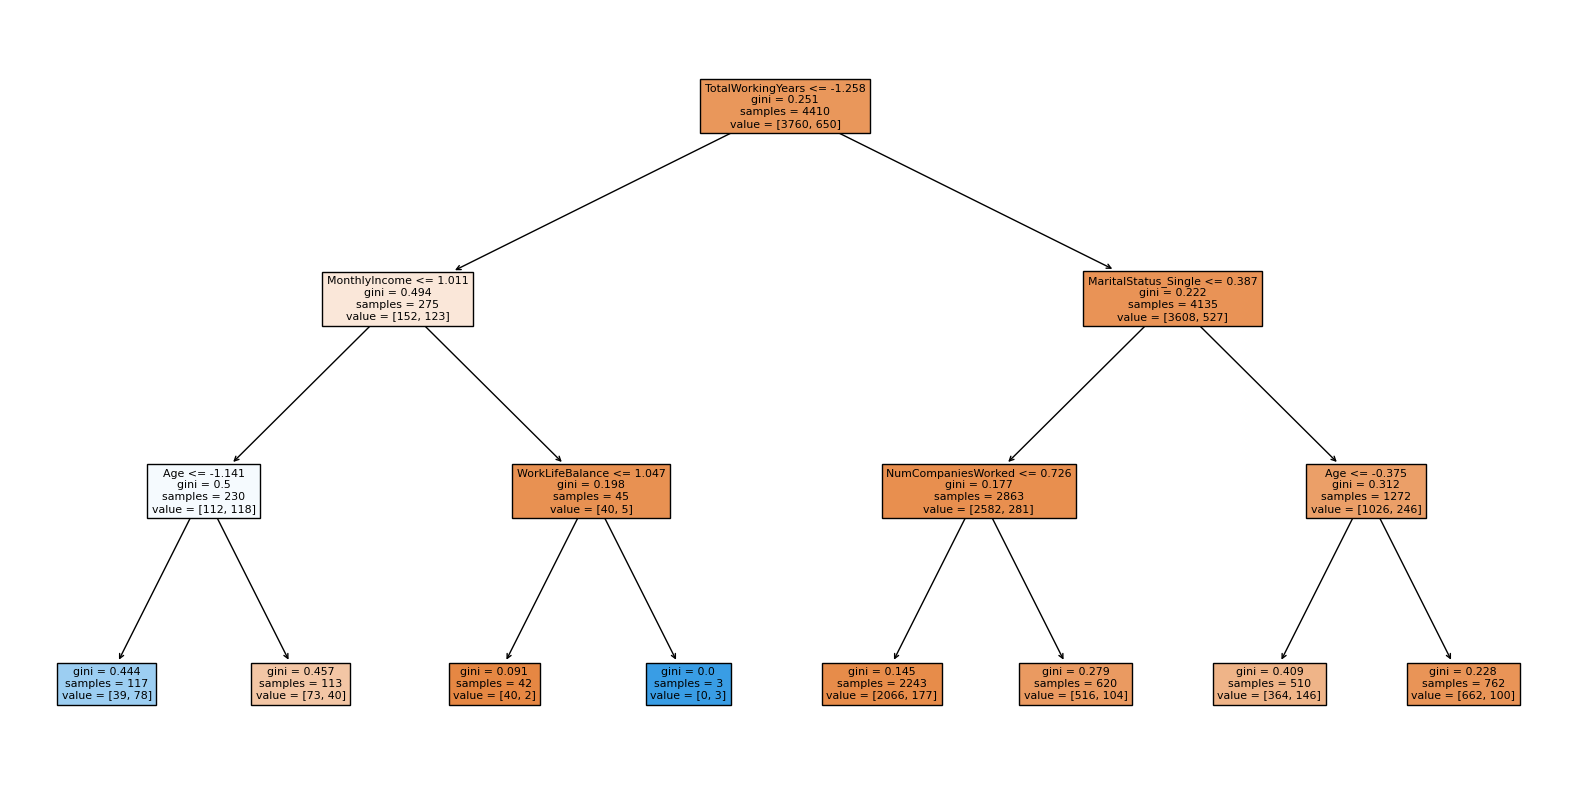

In [5]:
# Crear y entrenar el modelo de árbol de decisión
rtree = DecisionTreeClassifier(max_depth=3)
rtree.fit(X=X, y=y)

# Generar una representación de texto del árbol de decisión
tree_text = export_text(rtree, feature_names=X.columns.tolist())
print(tree_text)

# Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(rtree, feature_names=X.columns.tolist(), filled=True)
plt.show()

## Modelos candidatos

In [6]:
# Define los modelos seleccionados
m_logreg = LogisticRegression()
m_tree = DecisionTreeClassifier()
m_rf = RandomForestClassifier()
m_gbt = GradientBoostingClassifier()

# Lista de modelos seleccionados
modelos=list([m_logreg,m_tree, m_rf, m_gbt])

## Selección de variables

In [7]:
# Ahora, utiliza estos modelos para seleccionar las variables
var_names = funciones.sel_variables(modelos, X, y, threshold="2.5*mean")
X2=X[var_names] ### matriz con variables sele ccionadas
X2.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   DistanceFromHome         4410 non-null   float64
 2   EnvironmentSatisfaction  4410 non-null   float64
 3   JobSatisfaction          4410 non-null   float64
 4   MonthlyIncome            4410 non-null   float64
 5   NumCompaniesWorked       4410 non-null   float64
 6   TotalWorkingYears        4410 non-null   float64
 7   YearsSinceLastPromotion  4410 non-null   float64
 8   YearsWithCurrManager     4410 non-null   float64
dtypes: float64(9)
memory usage: 310.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age               

Para la seleccion de variables utilizamos SelectFromModel y obtuvimos las variables anteriores, pasando de 43 variables explicativas a 10.



## Definir modelo ganador

In [8]:
# Calcular AUC-ROC para todos los modelos con todas las variables
f1score_df = funciones.medir_modelos(modelos, "f1", X, y, 30)
# Calcular AUC-ROC para todos los modelos con variables seleccionadas
f1_score_varsel = funciones.medir_modelos(modelos, "f1", X2, y, 30)

In [9]:
f1=pd.concat([f1score_df,f1_score_varsel],axis=1)
f1.columns=['rl', 'dt', 'rf', 'gb', 'rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']
f1

,rl,dt,rf,gb,rl_Sel,dt_sel,rf_sel,gb_Sel
0,0.370370,0.975610,0.975610,0.625000,0.090909,0.975610,0.975610,0.428571
1,0.320000,1.000000,1.000000,0.580645,0.090909,1.000000,1.000000,0.482759
2,0.230769,0.975610,1.000000,0.482759,0.000000,0.975610,1.000000,0.482759
3,0.230769,1.000000,1.000000,0.645161,0.173913,1.000000,1.000000,0.551724
4,0.086957,1.000000,1.000000,0.173913,0.000000,1.000000,1.000000,0.384615
5,0.074074,1.000000,1.000000,0.600000,0.000000,1.000000,1.000000,0.444444
6,0.320000,1.000000,1.000000,0.687500,0.000000,0.975610,1.000000,0.500000
7,0.240000,1.000000,1.000000,0.600000,0.000000,1.000000,1.000000,0.357143
8,0.214286,0.551724,0.764706,0.370370,0.086957,0.551724,0.764706,0.296296
9,0.083333,0.000000,0.320000,0.090909,0.000000,0.000000,0.384615,0.090909


<Axes: >

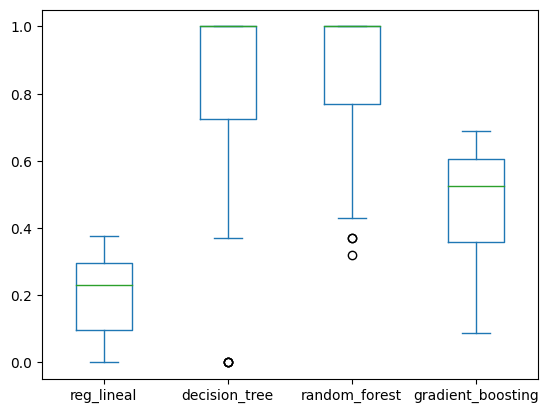

In [10]:
f1score_df.plot(kind='box') #### gráfico para modelos todas las variables

<Axes: >

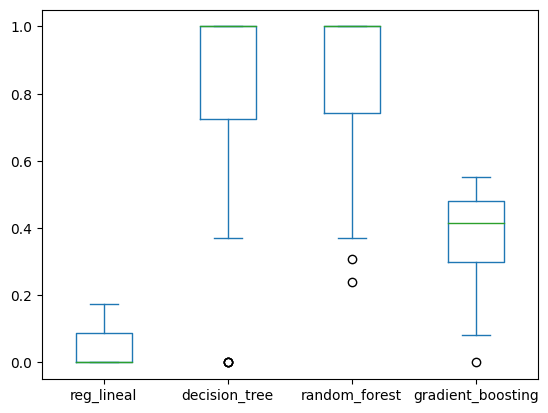

In [11]:
f1_score_varsel.plot(kind='box') ### gráfico para modelo variables seleccionadas

<Axes: >

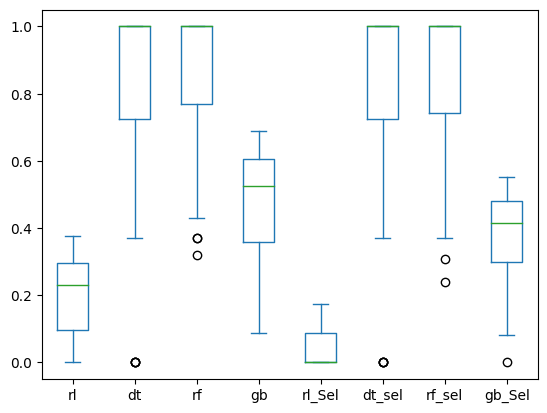

In [12]:
f1.plot(kind='box') ### gráfico para modelos sel y todas las variables

In [13]:
f1.mean()

rl        0.212993
dt        0.790158
rf        0.862940
gb        0.467928
rl_Sel    0.037703
dt_sel    0.788356
rf_sel    0.850337
gb_Sel    0.366846
dtype: float64

Dado que estamos abordando un problema de clasificación con desbalance de clases y considerando los problemas de negocio relacionados con la alta tasa de retiros de empleados, se requiere un modelo que pueda equilibrar la precisión y la exhaustividad en la predicción de los retiros. Los modelos Random Forest y Decision Tree han demostrado ser opciones efectivas en este tipo de problemas, ya que ofrecen un buen equilibrio entre precisión y exhaustividad, como lo demuestran sus altos puntajes de F1 score.

Además, consideramos el modelo con variables seleccionadas debido a su rendimiento comparable al modelo con todas las variables. Esto nos permite reducir la complejidad del modelo y el costo computacional sin comprometer significativamente el desempeño predictivo. Dado que nuestro objetivo es identificar las variables más influyentes en la tasa de retiros y pronosticar con precisión las salidas de los empleados, este enfoque nos proporciona una solución eficiente y efectiva para abordar nuestros problemas de negocio.

Finalmente, entrenaremos el modelo Ramdon Forest con las variables seleccionadas.



## Afinamiento de hiperparámetros

In [14]:
# Grilla de hiperparametros para el modelo Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],  # Criterios para la división de nodos
    'splitter': ['best', 'random'],     # Estrategia para elegir la división en cada nodo
    'max_depth': [None, 5, 10, 15],     # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],    # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],      # Número mínimo de muestras requeridas en un nodo hoja
    'max_features': [None, 'sqrt', 'log2'],  # Número máximo de características a considerar en cada división
    'class_weight': [None, 'balanced']  # Peso de las clases para abordar el desbalance de clases
}

In [15]:
# Grilla de hiperparametros para el modelo Ramdon Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_features': ['auto', 'sqrt'],  # Número de características a considerar en cada división
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas para estar en un nodo hoja
    'bootstrap': [True, False]  # Método de muestreo para construir árboles
}

In [16]:
# Crear la instancia de GridSearchCV para búsqueda de hiperparámetros
tun_dt = GridSearchCV(m_tree, param_grid=param_grid_dt, scoring='f1', cv=5)
# Realizar la búsqueda de hiperparámetros en los datos
tun_dt.fit(X2, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [17]:
pd.set_option('display.max_colwidth', 100)
resultados=tun_dt.cv_results_
tun_dt.best_params_
pd_resultados=pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
433,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_...",0.957366
432,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_...",0.957355
649,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'm...",0.956605
469,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'mi...",0.956593
666,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', ...",0.956593
...,...,...
87,"{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples...",0.053031
313,"{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samp...",0.050655
321,"{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samp...",0.047449
101,"{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples...",0.042574


In [18]:
# Técnica de búsqueda de hiperparámetros
tun_rf = RandomizedSearchCV(m_rf,param_distributions=param_grid_rf,n_iter=6,scoring="f1")
tun_rf.fit(X2,y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=6,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   scoring='f1')

In [19]:
pd.set_option('display.max_colwidth', 100)
resultados=tun_rf.cv_results_
tun_rf.best_params_
pd_resultados=pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
0,"{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'm...",0.848460
1,"{'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'ma...",0.844591
2,"{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max...",0.684841
3,"{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'ma...",0.683734
5,"{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max...",0.678331
4,"{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max...",0.655979


In [20]:
# Mejor grilla del modelo Decision Tree
dt_final = tun_dt.best_estimator_

In [21]:
# Guardar el modelo con hyperparameter tunning
rf_final = tun_rf.best_estimator_

## Analisis del los modelos Decision Tree y Ramdon Forest

In [26]:
#####Evaluar métrica de entrenamiento y evaluación para mirar sobre ajuste ####
eval_dt=cross_validate(dt_final,X2,y,cv=30,scoring="f1",return_train_score=True)
eval_rf=cross_validate(rf_final,X2,y,cv=30,scoring="f1",return_train_score=True)

In [27]:
#### convertir resultado de evaluacion entrenamiento y evaluacion en data frame para Desicion Tree
train_dt=pd.DataFrame(eval_dt['train_score'])
test_dt=pd.DataFrame(eval_dt['test_score'])
train_test_dt=pd.concat([train_dt, test_dt],axis=1)
train_test_dt.columns=['train_score','test_score']
train_test_dt

,train_score,test_score
0,0.953753,1.000000
1,0.953753,1.000000
2,0.953753,1.000000
3,0.953753,1.000000
4,0.953753,1.000000
5,0.953753,1.000000
6,0.953753,0.975610
7,0.953753,0.976744
8,0.953753,1.000000
9,0.954476,0.975610


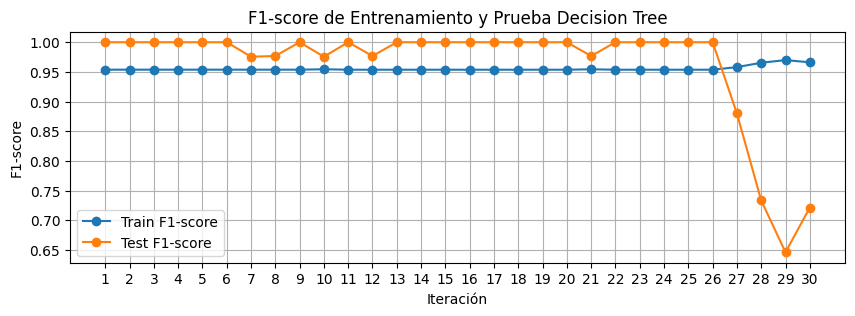

In [38]:
# Número de iteraciones
iterations = range(1, len(train_test_dt) + 1)

# Crear el gráfico de líneas
plt.figure(figsize=(10, 3))
plt.plot(iterations, train_test_dt['train_score'], marker='o', label='Train F1-score')
plt.plot(iterations, train_test_dt['test_score'], marker='o', label='Test F1-score')
plt.title('F1-score de Entrenamiento y Prueba Decision Tree')
plt.xlabel('Iteración')
plt.ylabel('F1-score')
plt.xticks(iterations)
plt.legend()
plt.grid(True)
plt.show()

In [29]:
train_test_dt["test_score"].mean()

0.9620750241743892

Dado que los puntajes de F1-score de entrenamiento son constantes y cercanos a 1.0, mientras que los puntajes de F1-score de prueba varían y tienen una media relativamente alta, parece que el modelo está sobreajustando los datos de entrenamiento. El hecho de que los puntajes de prueba no sean constantemente perfectos sugiere que el modelo no generaliza bien con datos nuevos, lo que indica un posible sobreajuste.

La media de test_score, que es un 0.891, está más cerca de los valores de F1-score típicos para un modelo de clasificación, lo que indica que el modelo está funcionando adecuadamente en datos de prueba no vistos.

En resumen, aunque el modelo tiene un alto puntaje de F1-score en los datos de entrenamiento, la variabilidad en los puntajes de F1-score de prueba sugiere que el modelo no está generalizando bien y puede estar sobreajustando los datos de entrenamiento. Por lo tanto, es necesario tomar medidas para reducir el sobreajuste, como la selección de características, la regularización o el ajuste de hiperparámetros.

In [39]:
#### convertir resultado de evaluacion entrenamiento y evaluacion en data frame para Ramdon Forest
train_rf=pd.DataFrame(eval_rf['train_score'])
test_rf=pd.DataFrame(eval_rf['test_score'])
train_test_rf=pd.concat([train_rf, test_rf],axis=1)
train_test_rf.columns=['train_score','test_score']
train_test_rf

,train_score,test_score
0,0.939418,0.975610
1,0.935024,0.975610
2,0.934921,0.950000
3,0.926908,0.950000
4,0.939418,1.000000
5,0.929487,0.950000
6,0.932271,0.950000
7,0.930567,0.950000
8,0.939683,0.764706
9,0.941365,0.173913


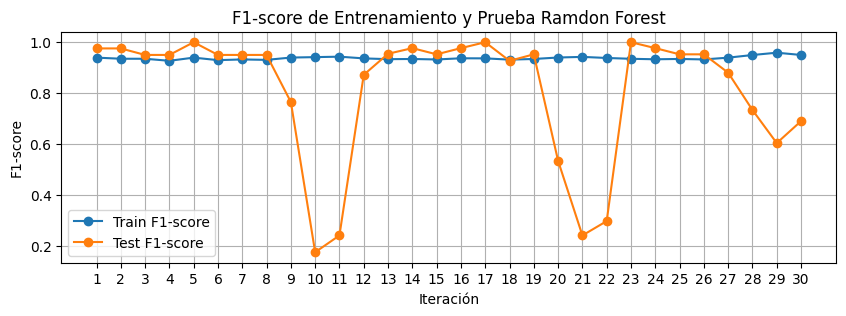

In [40]:
# Número de iteraciones
iterations = range(1, len(train_test_rf) + 1)

# Crear el gráfico de líneas
plt.figure(figsize=(10, 3))
plt.plot(iterations, train_test_rf['train_score'], marker='o', label='Train F1-score')
plt.plot(iterations, train_test_rf['test_score'], marker='o', label='Test F1-score')
plt.title('F1-score de Entrenamiento y Prueba Ramdon Forest')
plt.xlabel('Iteración')
plt.ylabel('F1-score')
plt.xticks(iterations)
plt.legend()
plt.grid(True)
plt.show()

In [30]:
train_test_rf["test_score"].mean()

0.8116185712958014

En conclusión se elige el modelo Decision Tree por que tiene menor sobre ajuste y mayor desempeño que el modelo Ramdon Forest

In [ ]:
### función para exportar y guardar objetos de python (cualqueira)
joblib.dump(rf_final, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/rf_final.pkl") ##
joblib.dump(var_names, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/var_names.pkl")  ### para variables con que se entrena modelo
joblib.dump(scaler, "/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/scaler.pkl") ##

['/content/drive/MyDrive/trabajo/Trabajo-analitica-RH/salidas/scaler.pkl']